In [1]:
import pandas as pd
import numpy as np
import nltk
import json
import time
import random
import scipy.sparse
import flor

from stop_words import get_stop_words
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import average_precision_score, recall_score, precision_recall_fscore_support

/home/eric/anaconda3/envs/rise/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
flor.setNotebookName('tutorial.ipynb')

In [3]:
@flor.func
def preprocessing(data_loc, intermediate_X, intermediate_y, **kwargs):
    '''

    Data Preprocessing

    '''
    print("DATA PREPROCESSING")
#     data = pd.read_json(data_loc)
#     X = data['text']
#     y = data['rating'].astype(np.float64)
    
#     en_stop = get_stop_words('en')

#     def filter_sentence(el):
#         tokens = word_tokenize(el)
#         tokens = [word for word in tokens if word.isalpha()]
#         tokens = [word for word in tokens if word not in en_stop]
#         tokens = stem_words(tokens)
#         tokens = lemma_words(tokens)

#         ret_str = " ".join(tokens) 

#         return ret_str 


#     #Credit to https://www.kdnuggets.com/2018/03/text-data-preprocessing-walkthrough-python.html
#     #for stem_words and lemma_words
#     def stem_words(words):
#         stemmer = PorterStemmer()
#         stems = []
#         for word in words:
#             stem = stemmer.stem(word)
#             stems.append(stem)
#         return stems

#     def lemma_words(words):
#         lemmatizer = WordNetLemmatizer()
#         lemmas = []
#         for word in words:
#             lemma = lemmatizer.lemmatize(word, pos='v')
#             lemmas.append(lemma)
#         return lemmas

#     start_time = time.time()
#     X = [filter_sentence(el) for el in X]
#     print("--- %s seconds ---" % (time.time() - start_time))

#     y_new = []
#     for el in y:
#         ret = 0
#         if el <= 5:
#             ret = 0
#         else:
#             ret = 1
#         y_new.append(ret)
#     y = y_new
    with open('data_clean_X.json') as json_data:
        X = json.load(json_data)
        json_data.close()
    with open('data_clean_y.json') as json_data:
        y = json.load(json_data)
        json_data.close()

    with open(intermediate_X, 'w') as outfile:
       json.dump(X, outfile)
    with open(intermediate_y, 'w') as outfile:
       json.dump(y, outfile)

In [4]:
# vectorizer = TfidfVectorizer()
# start_time = time.time()
# X = vectorizer.fit_transform(X)
# print("--- %s seconds ---" % (time.time() - start_time))
# print('Shape of Sparse Matrix: ', X.shape)

In [5]:
@flor.func
def split(intermediate_X, intermediate_y, X_train, X_test, y_train, y_test, **kwargs):
    with open(intermediate_X) as json_data:
        X = json.load(json_data)
        json_data.close()
    with open(intermediate_y) as json_data:
        y = json.load(json_data)
        json_data.close()
    X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.20, random_state=92)
#     def train_drop(el):
#         tokens = word_tokenize(el)
#         tokens = [el for el in tokens if random.random() >= 0.75]
#         ret_str = " ".join(tokens) 
#         return ret_str 
#     X_tr = [train_drop(el) for el in X_tr]
    vectorizer = TfidfVectorizer()
    start_time = time.time()
    vectorizer.fit(X_tr)
    X_tr = vectorizer.transform(X_tr)
    X_te = vectorizer.transform(X_te)
    with open(y_train, 'w') as outfile:
        json.dump(y_tr, outfile)
    with open(y_test, 'w') as outfile:
        json.dump(y_te, outfile)

    print("saving sparse matrices")
    scipy.sparse.save_npz(X_train, X_tr)
    scipy.sparse.save_npz(X_test, X_te)

In [6]:
@flor.func
def train_test(X_train, X_test, y_train, y_test, precision, recall, **kwargs):
    print("inside here!")
    X_train = scipy.sparse.load_npz(X_train)
    X_test = scipy.sparse.load_npz(X_test)
    with open(y_train) as json_data:
        y_train = json.load(json_data)
        json_data.close()
    with open(y_test) as json_data:
        y_test = json.load(json_data)
        json_data.close()
    print("received data")
    clf = RandomForestClassifier(n_estimators=50).fit(X_train, y_train)
#     nn = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(2, ), random_state=1)
#     nn.fit(X_train, y_train)
#     nb = MultinomialNB().fit(X_train, y_train)
    print("training")
    y_pred = clf.predict(X_test)
    
    print("predicting") 
    
    prec, rec, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')
    
    output = open(precision, 'w')
    output.write(str(prec))
    output.close()
    
    output = open(recall, 'w')
    output.write(str(rec))
    output.close()
    

In [7]:
with flor.Experiment("risecamp_demo") as ex:
    ex.groundClient('git') #use "git" from grit and "ground" for ground
    
    data = ex.artifact('data.json', 'data_loc')
    preprocessing = ex.action(preprocessing, [data])
    data_x = ex.artifact('data_clean_X.json', 'intermediate_X', preprocessing)
    data_y = ex.artifact('data_clean_y.json', 'intermediate_y', preprocessing)
    
    do_split = ex.action(split, [data_x, data_y])
    X_train = ex.artifact('x_train.npz', 'X_train', do_split)
    X_test = ex.artifact('x_test.npz', 'X_test', do_split)
    y_train = ex.artifact('y_train.json', 'y_train', do_split)
    y_test = ex.artifact('y_test.json', 'y_test', do_split)
    
    do_test = ex.action(train_test, [X_train, X_test, y_train, y_test])
    precision = ex.artifact('precision.txt', 'precision', do_test)
    recall = ex.artifact('recall.txt', 'recall', do_test)
    

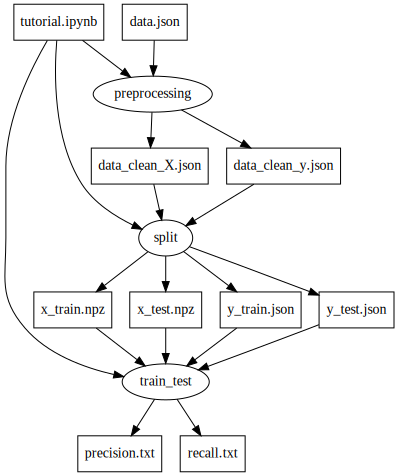

In [8]:
precision.plot()

In [9]:
precision.pull()

DATA PREPROCESSING
saving sparse matrices
inside here!
received data
training
predicting
